# Estimating deforestation in the Amazon

The goal is to estimate the fraction of the Amazon rainforest lost between 2000 and 2015. The data contains gold-standard deforestation labels for parcels that were collected through field visits (1), as well as predictions of forest cover based on applying computer vision to satellite imagery (2).

1. E. L. Bullock, C. E. Woodcock, C. Souza Jr, P. Olofsson, Satellite‐based estimates reveal widespread forest degradation in the Amazon. Global Change Biology 26(5), 2956–2969 (2020).
2. J. O. Sexton, J. X-P. Song, M. Feng, P. Noojipady, A. Anand, C. Huang, D-H. Kim, K. M. Collins, S. Channan, C. DiMiceli, J. R. Townshend, Global, 30-m resolution continuous fields of tree cover: Landsat-based rescaling of MODIS vegetation continuous fields with lidar-based estimates of error. International Journal of Digital Earth 6(5), 427–448 (2013).

### Import necessary packages

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import numpy as np
import pandas as pd
from ppi_py.datasets import load_dataset
from ppi_py import ppi_mean_ci, classical_mean_ci
from tqdm import tqdm
from scipy.optimize import brentq
from utils import *

### Import the forest data set

Load the data. The data set contains gold-standard deforestation labels (```Y```) and predicted deforestation labels (```Yhat```).

In [2]:
dataset_folder = "./data/"
data = load_dataset(dataset_folder, "forest")
Y_total = data["Y"]
Yhat_total = data["Yhat"]

### Problem setup

Specify the error level (```alpha```), range of values for the labeled data set size (```ns```), and number of trials (```num_trials```).

Compute the ground-truth value of the estimand.

In [3]:
alpha = 0.05
n_total = Y_total.shape[0]  # Total number of labeled examples
ns = np.linspace(50, 500, 10).astype(
    int
)  # Test for different numbers of labeled examples
num_trials = 100

# True mean (computed on all labels)
true_theta = Y_total.mean()

### Construct intervals

Form confidence intervals for all methods and problem parameters. A dataframe with the following columns is formed:
1. ```method``` (one of ```PPI```, ```Classical```, and ```Imputation```)
2. ```n``` (labeled data set size, takes values in ```ns```)
3. ```lower``` (lower endpoint of the confidence interval)
4. ```upper``` (upper endpoint of the confidence interval)
5. ```trial``` (index of trial, goes from ```0``` to ```num_trials-1```)

In [4]:
# Run prediction-powered inference and classical inference for many values of n
results = []
for i in tqdm(range(ns.shape[0])):
    for j in range(num_trials):
        # Prediction-Powered Inference
        n = ns[i]
        rand_idx = np.random.permutation(n_total)
        _Yhat = Yhat_total[rand_idx[:n]]
        _Y = Y_total[rand_idx[:n]]
        _Yhat_unlabeled = Yhat_total[n:]

        ppi_ci = ppi_mean_ci(_Y, _Yhat, _Yhat_unlabeled, alpha=alpha)

        # Classical interval
        classical_ci = classical_mean_ci(_Y, alpha=alpha)

        # Append results
        results += [
            pd.DataFrame(
                [
                    {
                        "method": "PPI",
                        "n": n,
                        "lower": ppi_ci[0],
                        "upper": ppi_ci[1],
                        "trial": j,
                    }
                ]
            )
        ]
        results += [
            pd.DataFrame(
                [
                    {
                        "method": "Classical",
                        "n": n,
                        "lower": classical_ci[0],
                        "upper": classical_ci[1],
                        "trial": j,
                    }
                ]
            )
        ]

# Imputed CI
imputed_ci = classical_mean_ci(Yhat_total > 0.5, alpha=alpha)
results += [
    pd.DataFrame(
        [
            {
                "method": "Imputation",
                "n": np.nan,
                "lower": imputed_ci[0],
                "upper": imputed_ci[1],
                "trial": 0,
            }
        ]
    )
]

df = pd.concat(results, axis=0, ignore_index=True)
df["width"] = df["upper"] - df["lower"]

100%|██████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.41it/s]


### Plot results

Plot:
1. Five randomly chosen intervals from the dataframe for PPI and the classical method, and the imputed interval;
2. The average interval width for PPI and the classical method, together with a scatterplot of the widths from the five random draws.

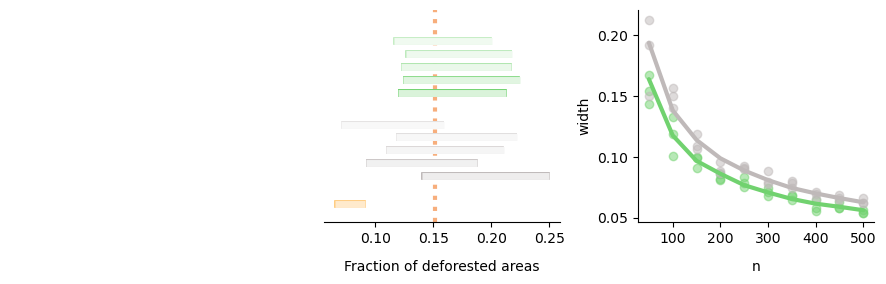

In [5]:
make_plots(
    df,
    "./plots/forest.pdf",
    n_idx=3,
    intervals_xlabel="Fraction of deforested areas",
    true_theta=true_theta,
)

### Power experiment

For PPI and the classical approach, find the smallest value of ```n``` such that the method has power 80% against the null that there is no deforestation, $H_0: \text{deforestation} \leq 0$.

In [6]:
# Find n such that we reject H0: fraction of deforested areas <=0 with probability 80% using a test at level alpha
num_experiments = 100
list_rand_idx = [
    np.random.permutation(n_total) for i in range(num_experiments)
]


def _to_invert_ppi(n):
    n = int(n)
    nulls_rejected = 0
    # Data setup
    for i in range(num_experiments):
        rand_idx = list_rand_idx[i]
        _Yhat = Yhat_total[rand_idx[:n]]
        _Y = Y_total[rand_idx[:n]]
        _Yhat_unlabeled = Yhat_total[rand_idx[n:]]

        ppi_ci = ppi_mean_ci(_Y, _Yhat, _Yhat_unlabeled, alpha=alpha)
        if ppi_ci[0] > 0:
            nulls_rejected += 1
    return nulls_rejected / num_experiments - 0.8


def _to_invert_classical(n):
    n = int(n)
    nulls_rejected = 0
    # Data setup
    for i in range(num_experiments):
        rand_idx = list_rand_idx[i]
        _Y = Y_total[rand_idx[:n]]

        classical_ci = classical_mean_ci(_Y, alpha=alpha)

        if classical_ci[0] > 0:
            nulls_rejected += 1
    return nulls_rejected / num_experiments - 0.8

In [7]:
n_ppi = int(brentq(_to_invert_ppi, 5, 500, xtol=1))
n_classical = int(brentq(_to_invert_classical, 10, 500, xtol=1))
print(
    f"The PPI test requires n={n_ppi} labeled data points to reject the null."
)
print(
    f"The classical test requires n={n_classical} labeled data points to reject the null."
)

The PPI test requires n=29 labeled data points to reject the null.
The classical test requires n=38 labeled data points to reject the null.
